In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 6.0)

import xml.etree.ElementTree as ET

In [2]:
mtu = 1500

baseRTTs = [i for i in range(10,10000,1000)]
bandwidths = [i for i in range(10,100,10)]

In [3]:
losses = []
thps = []
rtts = []
cwnds = []
for baseRTT in baseRTTs:
    for bandwidth in bandwidths:
        prefix_file_name = 'SimpleTcpStats-'+str(bandwidth)+'Mbps-'+str(baseRTT)+'us'

        flowmon_filename = prefix_file_name+'.flowmonitor'
        tree = ET.parse(flowmon_filename)
        root = tree.getroot()

        # Find the flow ID of the flow of interest
        for Ipv4FlowClassifier in root.iter('Ipv4FlowClassifier'):
            for Flow in Ipv4FlowClassifier.iter('Flow'):
                if Flow.attrib['sourceAddress'] == '10.0.2.1':
                    flow_id = Flow.attrib['flowId']
                    break

        # Extract the stats regarding the flow of interest
        for FlowStats in root.iter('FlowStats'):
            if FlowStats.attrib != {}:
                continue
            for Flow in FlowStats.iter('Flow'):
                if Flow.attrib['flowId'] == flow_id:
                    timeFirstTxPacket = float(Flow.attrib['timeFirstTxPacket'].split('+')[1].split('ns')[0])
                    timeLastTxPacket = float(Flow.attrib['timeLastTxPacket'].split('+')[1].split('ns')[0])
                    txBytes = float(Flow.attrib['txBytes'])
                    txPackets = float(Flow.attrib['txPackets'])
                    lostPackets = float(Flow.attrib['lostPackets'])

                    thp = txBytes/mtu/(timeLastTxPacket-timeFirstTxPacket)*1e9 # packet-per-second
                    loss_rate = lostPackets/txPackets

    #                 print('Throughput: {} pps, Loss Rate: {}'.format(thp,loss_rate))
                    losses.append(loss_rate)
                    thps.append(thp)
                    break
            break

        # Calculate the median RTT of the flow
        rtt_filename = prefix_file_name+'-rtt.data'

        time_series_rtts = []
        with open(rtt_filename,'r') as f:
            for line in f:
                _, rtt = line.split()
                time_series_rtts.append(float(rtt))
        time_series_rtts = np.asarray(time_series_rtts)
        rtts.append(np.median(time_series_rtts))

        # Calculate the median cwnd of the flow
        cwnd_filename = prefix_file_name+'-cwnd.data'

        time_series_cwnds = []
        with open(cwnd_filename,'r') as f:
            for line in f:
                _, cwnd = line.split()
                time_series_cwnds.append(float(cwnd))
        time_series_cwnds = np.asarray(time_series_cwnds)
        cwnds.append(np.median(time_series_cwnds))
        
losses = np.asarray(losses)
thps = np.asarray(thps)
rtts = np.asarray(rtts)
cwnds = np.asarray(cwnds)

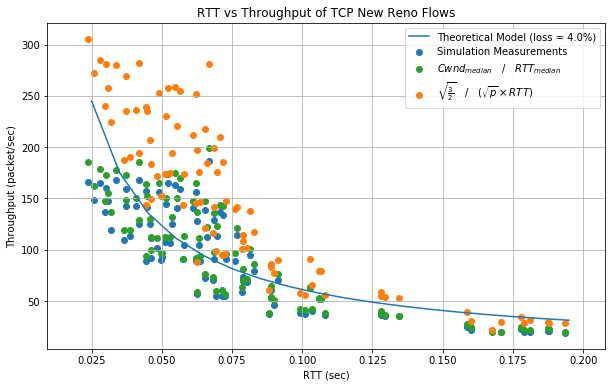

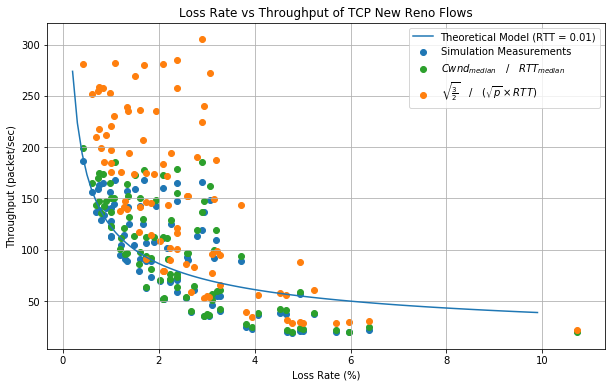

In [4]:
analytical_thps = math.sqrt(1.5)/np.multiply(np.sqrt(losses),rtts)
cwnd_estimate_thps = np.divide(cwnds,rtts)/mtu

model_loss = 0.04
model_rtts = np.arange(0.025,0.2,0.01)
model_thps = math.sqrt(1.5)/math.sqrt(model_loss)/model_rtts

plt.figure()
plt.scatter(rtts,thps, label='Simulation Measurements')
plt.scatter(rtts,cwnd_estimate_thps, c='C2', label=r"$Cwnd_{median}\quad/\quadRTT_{median}$")
plt.scatter(rtts,analytical_thps, c='C1', label=r"$\sqrt{\frac{3}{2}}\quad/\quad(\sqrt{p} \times RTT)$")
# plt.scatter(rtts,thps,
#             label='Simulation Measurements ({:.3f})'.format(np.corrcoef(thps,analytical_thps)[0,1]))
# plt.scatter(rtts,cwnd_estimate_thps, c='C2',
#             label='Cwnd/RTT ({:.3f})'.format(np.corrcoef(cwnd_estimate_thps,analytical_thps)[0,1]))
# plt.scatter(rtts,analytical_thps, c='C1',
#             label='√1.5 / (√p x RTT) ({:.3f})'.format(np.corrcoef(analytical_thps,analytical_thps)[0,1]))
plt.plot(model_rtts,model_thps, label='Theoretical Model (loss = {}%)'.format(model_loss*100))

plt.legend()
plt.ylabel('Throughput (packet/sec)')
plt.xlabel('RTT (sec)')
plt.title('RTT vs Throughput of TCP New Reno Flows')
plt.grid()
plt.show()

model_rtt = 0.01
model_losses = np.arange(0.2,10,0.1)
model_thps = math.sqrt(1.5)/np.sqrt(model_losses)/model_rtt

plt.figure()
plt.scatter(losses*100,thps, label='Simulation Measurements')
plt.scatter(losses*100,cwnd_estimate_thps, c='C2', label=r"$Cwnd_{median}\quad/\quadRTT_{median}$")
plt.scatter(losses*100,analytical_thps, c='C1', label=r"$\sqrt{\frac{3}{2}}\quad/\quad(\sqrt{p} \times RTT)$")
# plt.scatter(losses*100,thps,
#             label='Simulation ({:.3f})'.format(np.corrcoef(thps,analytical_thps)[0,1]))
# plt.scatter(losses*100,analytical_thps,
#             label='√1.5 / (√p x RTT) ({:.3f})'.format(np.corrcoef(analytical_thps,analytical_thps)[0,1]))
# plt.scatter(losses*100,cwnd_estimate_thps,
#             label='Cwnd / RTT ({:.3f})'.format(np.corrcoef(cwnd_estimate_thps,analytical_thps)[0,1]))
plt.plot(model_losses,model_thps, label='Theoretical Model (RTT = {})'.format(model_rtt))

plt.legend()
plt.ylabel('Throughput (packet/sec)')
plt.xlabel('Loss Rate (%)')
plt.title('Loss Rate vs Throughput of TCP New Reno Flows')
plt.grid()
plt.show()

In [5]:
cwnd_times = []
cwnds = []
with open('SimpleTcpStats-100Mbps-10us-cwnd.data','r') as f:
    for line in f:
        time, cwnd = line.split()
        cwnd_times.append(float(time))
        cwnds.append(float(cwnd))
cwnds = np.asarray(cwnds)

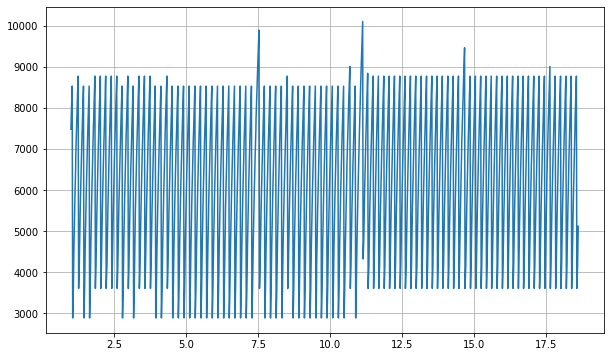

In [6]:
plt.plot(cwnd_times,cwnds)
# plt.ylim((0,1.5e5))
plt.grid()
plt.show()

In [14]:
rtt_times = []
rtts = []
with open('SimpleTcpStats-100Mbps-10us-rtt.data','r') as f:
    for line in f:
        time, rtt = line.split()
        rtt_times.append(float(time))
        rtts.append(float(rtt))
rtts = np.asarray(rtts)

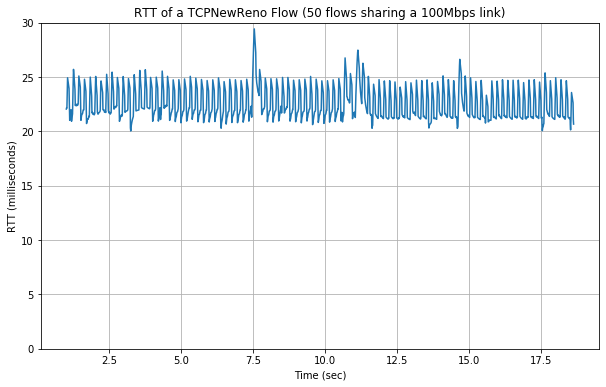

In [19]:
plt.figure()
plt.plot(rtt_times,)
plt.title('RTT of a TCPNewReno Flow (50 flows sharing a 100Mbps link)')
plt.xlabel('Time (sec)')
plt.ylabel('RTT (milliseconds)')
# plt.xlim((1.1,1.2))
plt.ylim((0.0,30))
plt.grid()
plt.show()

In [9]:
math.sqrt(3./2.)/math.sqrt(36./330.)/np.median(rtts)*1500.*8.

2044992.2525552055

In [10]:
np.median(cwnds)*8./np.median(rtts)

2418114.719818375